# Initial Set Up

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from textblob import TextBlob
import _pickle as cPickle
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

# NLP Pre-Processing: Data to Vectors

In [2]:
messages = pd.read_csv('Data/train.csv',
                       header=0)
messages = messages.dropna()

In [3]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [4]:
bow_transformer = CountVectorizer(\
                        analyzer=split_into_lemmas)\
                    .fit(messages['content'])
print(f'The transfromer has a vocabulary of\
        {len(bow_transformer.vocabulary_)}')

The transfromer has a vocabulary of        29222


In [5]:
messages_bow = bow_transformer\
                .transform(messages['content'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % \
        (100.0 * messages_bow.nnz / \
        (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (4008, 29222)
number of non-zeros: 497368
sparsity: 0.42%


In [6]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

# Training a Model

In [7]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 6.39 ms, sys: 1.3 ms, total: 7.69 ms
Wall time: 7.5 ms


In [8]:
all_predictions = spam_detector.predict(messages_tfidf)
print(f'Accuracy : {accuracy_score(messages['label'], all_predictions)}')

Accuracy : 0.8715069860279441


Text(0.5, 0, 'Predicted Label')

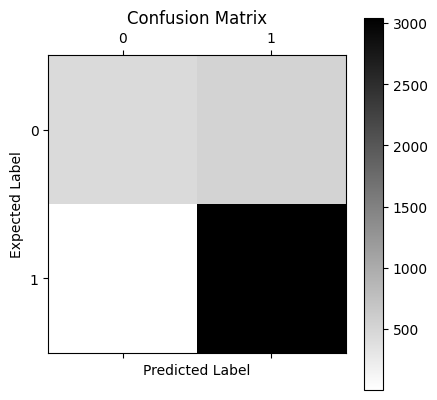

In [9]:
plt.matshow(confusion_matrix(messages['label'], all_predictions),
            cmap=plt.cm.binary,
            interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')

In [10]:
print(classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       1.00      0.47      0.64       966
        spam       0.86      1.00      0.92      3042

    accuracy                           0.87      4008
   macro avg       0.93      0.73      0.78      4008
weighted avg       0.89      0.87      0.85      4008



In [11]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [12]:
msg_train = messages['content']
label_train = messages['label']

In [13]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000],
   'classifier__kernel': ['linear']
   },
  {'classifier__C': [1, 10, 100, 1000],
   'classifier__gamma': [0.001, 0.0001],
   'classifier__kernel': ['rbf']
   },
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5),  # what type of cross validation to use
)

In [14]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm

In [ ]:
mean_test_score = svm_detector.cv_results_['mean_test_score']
std_test_score = svm_detector.cv_results_['std_test_score']
params = svm_detector.cv_results_['params']

for i in range(len(params)):
    print(f'{mean_test_score[i]} - {std_test_score[i]} - {params[i]}')

0.9935118508348356 - 0.002422164735528785 - {'classifier__C': 1, 'classifier__kernel': 'linear'}
0.9922637227156826 - 0.0035675228195742423 - {'classifier__C': 10, 'classifier__kernel': 'linear'}
0.9870237016696709 - 0.0038414129264918214 - {'classifier__C': 100, 'classifier__kernel': 'linear'}
0.984529936083636 - 0.003019270679005007 - {'classifier__C': 1000, 'classifier__kernel': 'linear'}
0.7589820704169663 - 0.00045878121593246273 - {'classifier__C': 1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.7589820704169663 - 0.00045878121593246273 - {'classifier__C': 1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}
0.7589820704169663 - 0.00045878121593246273 - {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.7589820704169663 - 0.00045878121593246273 - {'classifier__C': 10, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}
0.9770430353579224 - 0.005735912359647694 - {'classifier__C': 100, 'classifier__gamma': 0.001, 'classifie